<a href="https://colab.research.google.com/github/agojunior/CNN_LSTM_Energy/blob/main/ANTONIONEUROGEOINFO(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wtss
!pip install pandas
!pip install geopandas
!pip install numpy
!pip install io
!pip install requests
!pip install tqdm
!pip install tensorflow
import wtss
import pandas as pd
import geopandas as gpd
import numpy as np
import io, requests
import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.layers import Dropout

ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io


In [ ]:
rng = np.random.default_rng(20241117)

In [ ]:
base_dir = '/home/junior/'
pontos_path = base_dir + 'amostras_mangue.csv'
df = pd.read_csv('/content/amostras_mangue.csv')
print(df.axes)
# long / lat columns to geodataframe geomtry all other columns attributes
pontos = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"), data=df
)

[RangeIndex(start=0, stop=337, step=1), Index(['geometry', 'label_id', 'label_name', 'label', 'collection_date',
       'created_at', 'end_date', 'id', 'start_date', 'updated_at',
       'user_email', 'user_name', 'longitude', 'latitude'],
      dtype='object')]


In [ ]:
df = pd.read_csv('/content/amostras_mangue.csv')
pontos = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"), data=df
)
pontos.head()

,geometry,label_id,label_name,label,collection_date,created_at,end_date,id,start_date,updated_at,user_email,user_name,longitude,latitude
0,POINT (-44.54454 -3.00034),265,vegetação-arbutiva-arbórea,Vegetação arbustiva/arbórea,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,4,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.544539,-3.000342
1,POINT (-44.53551 -2.99893),272,corpo-d’água,Corpos d’água,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,5,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.535506,-2.998927
2,POINT (-44.24047 -2.99819),274,superfície-artificiai,Superfícies artificiais,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,6,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.240474,-2.998193
3,POINT (-44.43395 -2.89332),272,corpo-d’água,Corpos d’água,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,7,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.433947,-2.893324
4,POINT (-44.40708 -2.90055),265,vegetação-arbutiva-arbórea,Vegetação arbustiva/arbórea,2024-08-02T00:00:00Z,02-08-2024,31-07-2026,8,24-07-2024,02-08-2024,antonio.gomes.o.jr@gmail.com,ANTONIO GOMES DE OLIVEIRA JUNIOR,-44.407082,-2.900546


In [ ]:
groundTruth = pd.DataFrame({
    'id': np.asarray(pontos.id.values),
    'classification': np.asarray(pontos.label_name).T
})

# Save the DataFrame to a CSV file
groundTruth.to_csv('label2.csv', index=False)


In [ ]:
servico = wtss.WTSS('https://data.inpe.br/bdc/wtss/v4/')
cubo_s2 = servico['S2-16D-2']
start_date = '2023-06-01'
end_date = '2024-06-30'


attributes = ('B8A','B11','B04','NDVI')

In [ ]:
timeline = cubo_s2.timeline

ultima_data_disponivel = timeline[0]
primeira_data_disponivel = timeline[-1]

print(f'Intervalo: [{primeira_data_disponivel}, {ultima_data_disponivel}]')

Intervalo: [2024-09-29, 2018-01-01]


In [ ]:
start_date = '2023-06-01'
end_date = '2024-06-30'


attributes = ('B8A','B11','B04','NDVI', 'SCL')

# attributes = ('NDVI', 'SCL')

In [ ]:

# 'B8A','B11','B04','NDVI'
b8a_values = []
b11_values = []
b04_values = []
ndvi_values = []

scl_values = []
for id, geometry in tqdm.tqdm(zip(pontos.id.values,
                                  pontos.geometry.values),
                         desc="Processando dados", unit="data"):
  timeseries = cubo_s2.ts(attributes=attributes,
                            longitude=geometry.x,
                            latitude=geometry.y,
                            start_date=start_date,
                            end_date=end_date)


  ndvi_values.append(timeseries.values('NDVI'))
  b8a_values.append(timeseries.values('B8A')   )
  b11_values.append(timeseries.values('B11')   )
  b04_values.append(timeseries.values('B04')   )
  scl_values.append(timeseries.values('SCL')   )

Processando dados: 337data [04:57,  1.13data/s]


In [ ]:
ndvi = pd.DataFrame(data=np.asarray(ndvi_values).T,
                    columns=pontos.id.astype(str).values,  # Converte IDs para string
                    index=timeseries.timeline)

# Restaura o índice e renomeia a coluna de data
ndvi = ndvi.reset_index().rename(columns={'index': 'data'})

# Salva o DataFrame em um arquivo CSV
ndvi.to_csv('ndvi_sample.csv', index=False)

In [ ]:
scl = pd.DataFrame(data=np.asarray(scl_values).T,
                    columns=pontos.id.astype(str).values,  # Converte IDs para string
                    index=timeseries.timeline)

# Restaura o índice e renomeia a coluna de data
scl = scl.reset_index().rename(columns={'index': 'data'})

# Salva o DataFrame em um arquivo CSV
scl.to_csv('scl_sample.csv', index=False)

In [ ]:
b8a = pd.DataFrame(data = np.asarray(b8a_values).T,
                    columns=pontos.id.values,
                    index=timeseries.timeline)

b8a = b8a.reset_index().rename(columns={'index': 'data'})
b8a.to_csv('b8a_sample.csv')

In [ ]:
b11 = pd.DataFrame(data = np.asarray(b11_values).T,
                    columns=pontos.id.values,
                    index=timeseries.timeline)

b11 = b11.reset_index().rename(columns={'index': 'data'})
b11.to_csv('b11_sample.csv')

In [ ]:
b04 = pd.DataFrame(data = np.asarray(b04_values).T,
                    columns=pontos.id.values,
                    index=timeseries.timeline)

b04 = b04.reset_index().rename(columns={'index': 'data'})
b04.to_csv('b04_sample.csv')

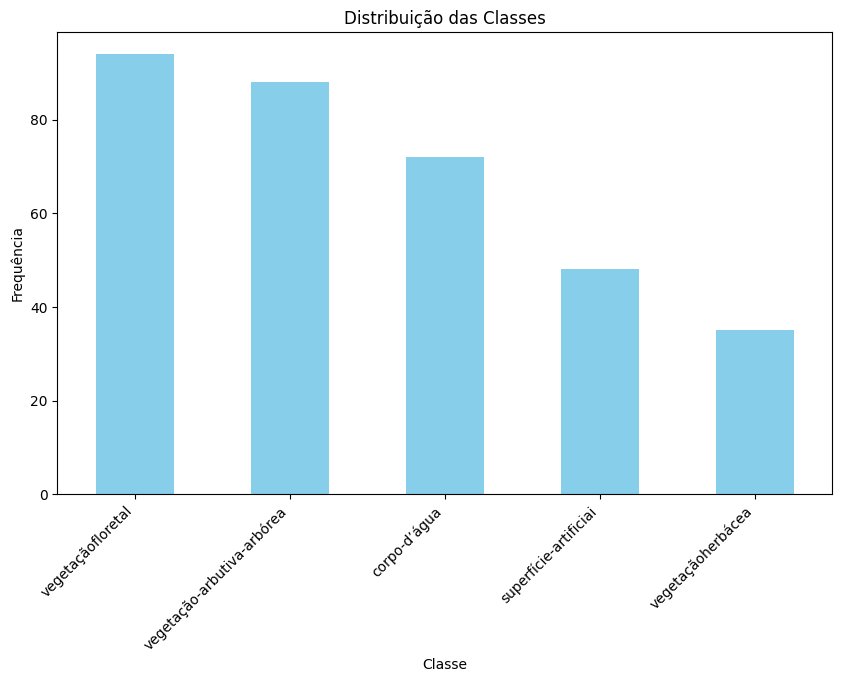

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho do arquivo CSV de classificação
classification_path = 'label2.csv'

# Carregar os dados de classificação
classification = pd.read_csv(classification_path)

# Contar a frequência de cada classe
class_counts = classification['classification'].value_counts()

# Plotar o histograma
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribuição das Classes')
plt.xlabel('Classe')
plt.ylabel('Frequência')
plt.xticks(rotation=45, ha='right')
plt.show()


Carregando os dados

In [ ]:
from sklearn.preprocessing import MinMaxScaler

ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'

ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

X = final_data_filtered[['ndvi', 'b8a', 'b4', 'b11']]
y = (final_data_filtered['classification']
              .apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else 0)).values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

LSTM Rasa

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7798 - loss: 3.3397 - val_accuracy: 0.8612 - val_loss: 0.6005
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8758 - loss: 0.5156 - val_accuracy: 0.7709 - val_loss: 1.5214
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8366 - loss: 0.7088 - val_accuracy: 0.8770 - val_loss: 0.4363
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8860 - loss: 0.4892 - val_accuracy: 0.8883 - val_loss: 0.3723
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8754 - loss: 0.3838 - val_accuracy: 0.8657 - val_loss: 0.3660
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8755 - loss: 0.4096 - val_accuracy: 0.9086 - val_loss: 0.4042
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8959 - loss: 0.3544 - val_accuracy: 0.8657 - val_loss: 0.4478
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8886 - loss: 0.3554 - val_accuracy: 0.8984 - val_

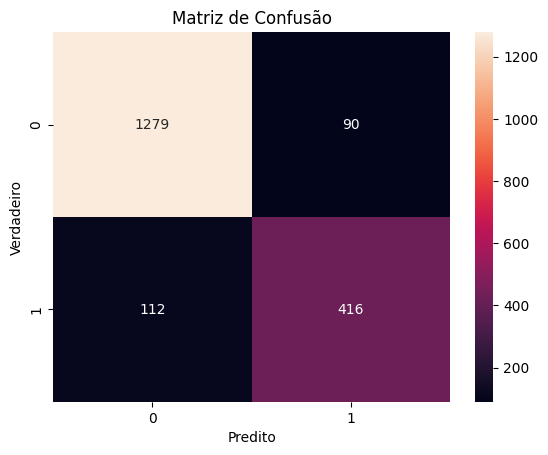

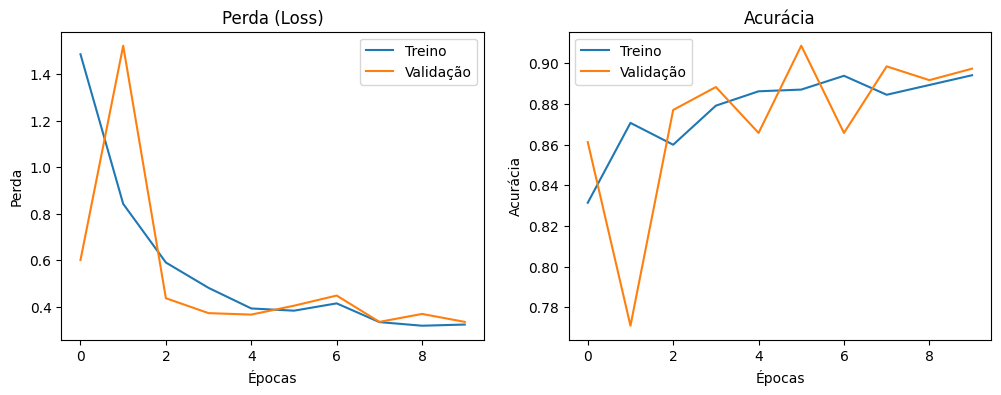

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))
L
# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


RNN Rasa

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8059 - loss: 28.2890 - val_accuracy: 0.8849 - val_loss: 4.5705
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8741 - loss: 3.7953 - val_accuracy: 0.8950 - val_loss: 2.8371
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8601 - loss: 3.0099 - val_accuracy: 0.8533 - val_loss: 4.9059
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8704 - loss: 3.4146 - val_accuracy: 0.8567 - val_loss: 3.8776
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8615 - loss: 3.3861 - val_accuracy: 0.8849 - val_loss: 1.7543
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8635 - loss: 2.9050 - val_accuracy: 0.8770 - val_loss: 2.2560
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8649 - loss: 2.3667 - val_accuracy: 0.9041 - val_loss: 2.5660
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8885 - loss: 1.9533 - val_accuracy: 0.8871 - val

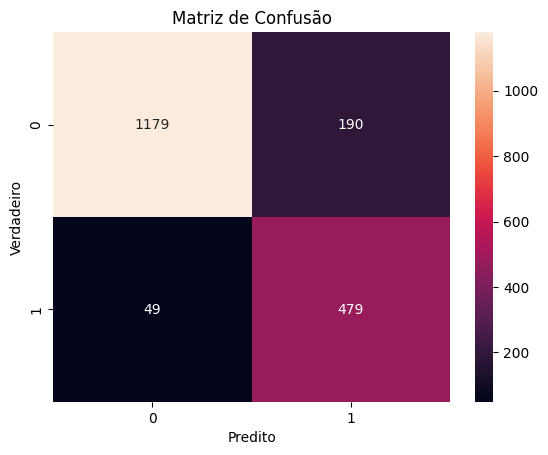

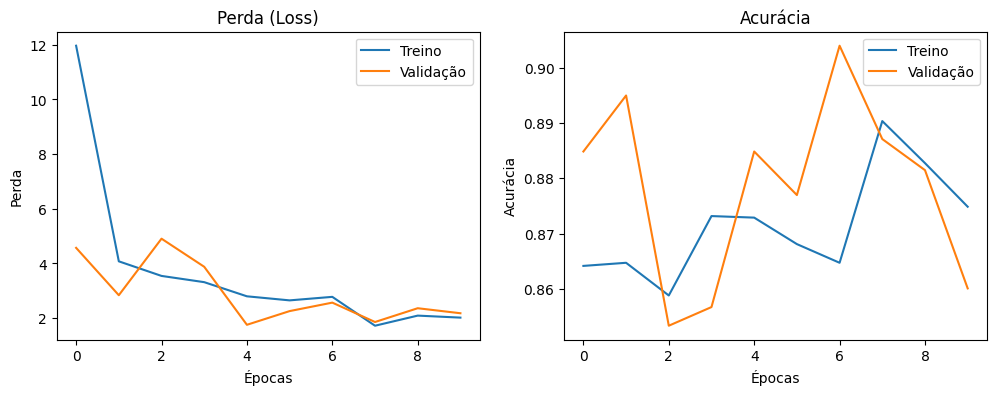

In [ ]:


model = Sequential()
model.add(SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,955 (31.08 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,304 (20.72 KB)

#Testando modelos mais profundos

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.6899 - loss: 2.5241 - val_accuracy: 0.8273 - val_loss: 0.6044
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7272 - loss: 1.0019 - val_accuracy: 0.7427 - val_loss: 0.5135
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7351 - loss: 0.5369 - val_accuracy: 0.8984 - val_loss: 0.3308
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8683 - loss: 0.3394 - val_accuracy: 0.8939 - val_loss: 0.3224
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8701 - loss: 0.3471 - val_accuracy: 0.8465 - val_loss: 0.4499
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8162 - loss: 0.4615 - val_accuracy: 0.8284 - val_loss: 0.4087
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8564 - loss: 0.3678 - val_accuracy: 0.8600 - val_loss: 0.3541
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8568 - loss: 0.3852 - val_acc

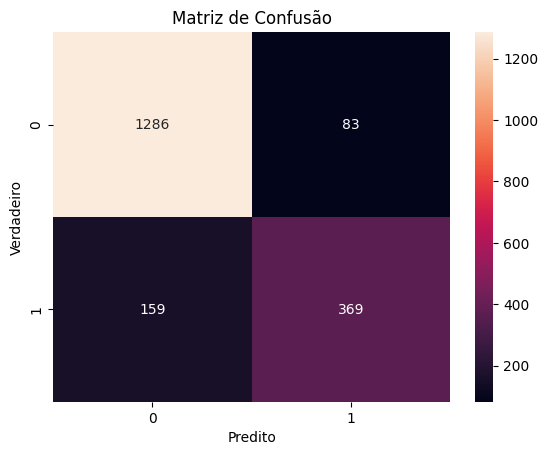

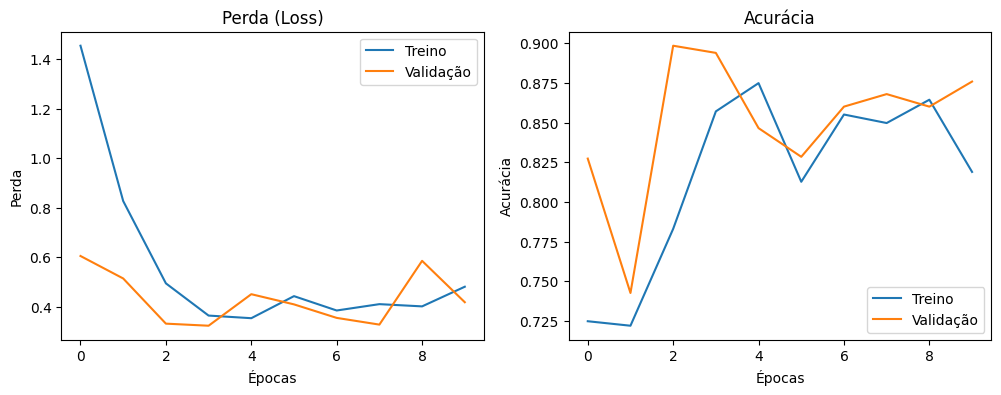

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                       │ (None, 4, 100)              │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_20 (LSTM)                       │ (None, 4, 100)              │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 462,005 (1.76 MB)

 Trainable params: 154,001 (601.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 308,004 (1.17 MB)

In [16]:


model = Sequential()
# Primeira camada LSTM
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Segunda camada LSTM
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
# Terceira camada LSTM
model.add(LSTM(50, activation='relu'))

# Camada densa final para a classificação
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

model.summary()

MLP Profundo

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7916 - loss: 18.0842 - val_accuracy: 0.6603 - val_loss: 17.1079
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8731 - loss: 3.9967 - val_accuracy: 0.8454 - val_loss: 3.3541
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8765 - loss: 2.4808 - val_accuracy: 0.8962 - val_loss: 2.1948
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8712 - loss: 2.3725 - val_accuracy: 0.8431 - val_loss: 2.7155
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8618 - loss: 3.0497 - val_accuracy: 0.8770 - val_loss: 2.4910
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8848 - loss: 1.7251 - val_accuracy: 0.8916 - val_loss: 1.6949
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8708 - loss: 1.8686 - val_accuracy: 0.9029 - val_loss: 2.5416
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8881 - loss: 1.8099 - val_accuracy: 0.9108 - va

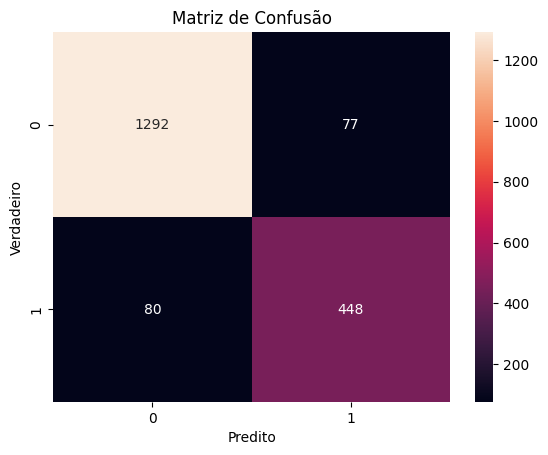

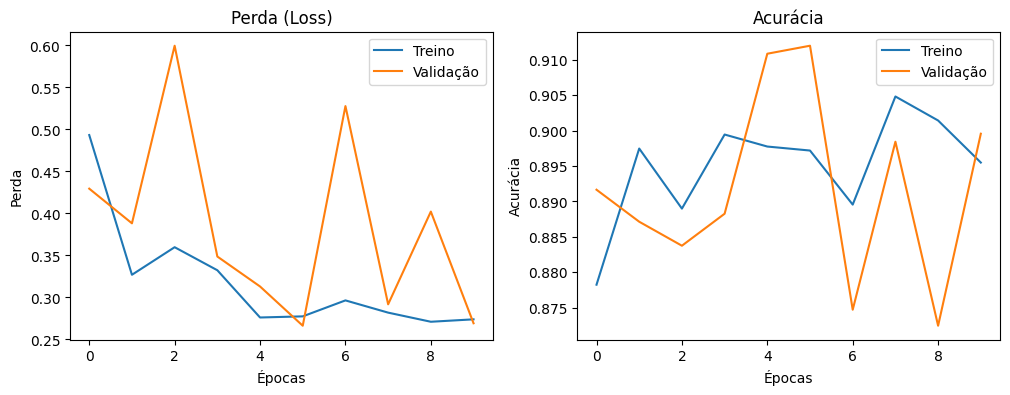

In [ ]:
model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Treinar o modelo com os dados de entrada X_train e as labels y_train
# model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(np.expand_dims(X_train, axis=-1), y_train, epochs=10, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(np.expand_dims(X_test, axis=-1), y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = (model.predict(np.expand_dims(X_test, axis=-1)) > 0.5).astype("int32")

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,837 (34.52 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,892 (23.02 KB)

In [ ]:

from sklearn.preprocessing import MinMaxScaler
ndvi_path = 'ndvi_sample.csv'
b8a_path = 'b8a_sample.csv'
b4_path = 'b04_sample.csv'
b11_path = 'b11_sample.csv'
scl_path = 'scl_sample.csv'
classification_path = 'label2.csv'
ndvi = pd.read_csv(ndvi_path)
b8a = pd.read_csv(b8a_path)
b4 = pd.read_csv(b4_path)
b11 = pd.read_csv(b11_path)
scl = pd.read_csv(scl_path)
classification = pd.read_csv(classification_path)

# Transformar os IDs para texto (string) nas bandas e no SCL
ndvi.columns = ndvi.columns.astype(str)
b8a.columns = b8a.columns.astype(str)
b4.columns = b4.columns.astype(str)
b11.columns = b11.columns.astype(str)
scl.columns = scl.columns.astype(str)

# Transformar o ID da classificação para texto (string)
classification['id'] = classification['id'].astype(str)

# Colocar os dados das bandas em formato longo (long format)
ndvi_long = pd.melt(ndvi, id_vars=['data'], var_name='id', value_name='ndvi')
b8a_long = pd.melt(b8a, id_vars=['data'], var_name='id', value_name='b8a')
b4_long = pd.melt(b4, id_vars=['data'], var_name='id', value_name='b4')
b11_long = pd.melt(b11, id_vars=['data'], var_name='id', value_name='b11')
scl_long = pd.melt(scl, id_vars=['data'], var_name='id', value_name='scl')

# Mesclar os dados das bandas e SCL
merged_data = pd.merge(ndvi_long, b8a_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b4_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, b11_long, on=['data', 'id'])
merged_data = pd.merge(merged_data, scl_long, on=['data', 'id'])

# Mesclar os dados das bandas e SCL com as classificações
final_data = pd.merge(merged_data, classification, on='id')

# Filtrar as linhas onde o valor de scl é 4, 5 ou 6
final_data_filtered = final_data[final_data['scl'].isin([4, 5, 6])]

# Remover a coluna 'scl' de final_data_filtered
final_data_filtered = final_data_filtered.drop(columns=['scl'])

y = final_data_filtered['classification'].apply(
    lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else (0 if x == 'vegetaçãoherbácea' else 2)
)

# Filtrar as linhas onde y é None (remover outras classes)
filtered_data = final_data_filtered[y.notnull()]
X = filtered_data[['ndvi', 'b8a', 'b4', 'b11']]
y = filtered_data['classification'].apply(lambda x: 1 if x == 'vegetação-arbutiva-arbórea' else (0 if x == 'vegetaçãoherbácea' else 2)).values

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5917 - loss: 0.9808 - val_accuracy: 0.6400 - val_loss: 0.7208
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7055 - loss: 0.6816 - val_accuracy: 0.7935 - val_loss: 0.5885
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7873 - loss: 0.6098 - val_accuracy: 0.7991 - val_loss: 0.5336
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8249 - loss: 0.5097 - val_accuracy: 0.8093 - val_loss: 0.4920
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8341 - loss: 0.4554 - val_accuracy: 0.8149 - val_loss: 0.4560
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8449 - loss: 0.4111 - val_accuracy: 0.8228 - val_loss: 0.4149
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8416 - loss: 0.3879 - val_accuracy: 0.8420 - val_loss: 0.3884
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8513 - loss: 0.3797 - val_accuracy: 0.8499 - val_

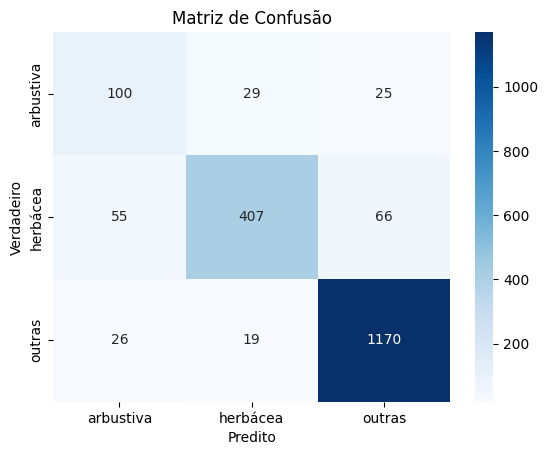

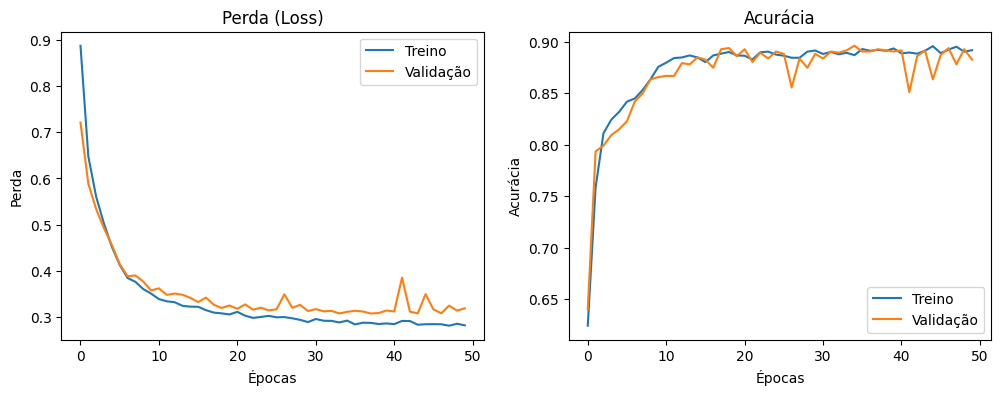

In [ ]:

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(3, activation='softmax'))

# Compilar o modelo com sparse_categorical_crossentropy para múltiplas classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = np.argmax(model.predict(X_test), axis=1)

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['arbustiva', 'herbácea', 'outras'],
            yticklabels=['arbustiva', 'herbácea', 'outras'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:

model = Sequential()
input_dim = X_train.shape[1]
model.add(Dense(64, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# Adicionar a camada de saída com 1 neurônio (saída binária) e ativação sigmoid para classificação binária
model.add(Dense(3, activation='softmax'))

# Compilar o modelo com sparse_categorical_crossentropy para múltiplas classes
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Avaliar o modelo
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Previsões
y_pred = np.argmax(model.predict(X_test), axis=1)

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['arbustiva', 'herbácea', 'outras'],
            yticklabels=['arbustiva', 'herbácea', 'outras'])
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

# Gráfico de perda (loss) e acurácia
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda (Loss)')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(unique)
print(counts)
a,b = np.unique(filtered_data['classification'].values, return_counts=True)
print(a)
print(b)